<a href="https://colab.research.google.com/github/astrapi69/DroidBallet/blob/master/MLG_D3_LC2_Classification_Models_Tackling_Class_Imbalance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><a target="_blank" href="https://academy.constructor.org/"><img src="https://jobtracker.ai/static/media/constructor_academy_colour.b86fa87f.png" width="200" style="background:none; border:none; box-shadow:none;" /></a> </center>

_____

<center> <h1> Classification Models - Tackling Class Imbalance (Live coding) </h1> </center>

<p style="margin-bottom:1cm;"></p>

_____

<center>Constructor Academy, 2024</center>

# Classification Models - Tackling Class Imbalance (Live coding)

__Topic covered__

- Logistic Regression
- Resampling using SMOTE
- Resampling using RandomUnderSampler
- Class imbalance with class weights
- Classification Metrics
- ROC curve score and plotting

In [ ]:
import imblearn

In [ ]:
# run this cell if you don't have imblearn installed

#!pip install imblearn --ignore-installed

## Load Dependencies

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.over_sampling import SMOTE # for oversampling the minority class, i.e generating synthetic samples
from imblearn.under_sampling import RandomUnderSampler # for undersampling the majority class

__Helper function__

<span style="color:orange">**The helper function below will plot the ROC curve, calculate AUC for a base model and the AUC of our logistic regression model.**</span>

In [ ]:
def plot_roc(y_test, proba_preds):

    # create linear line for dummy classifier with 50% random probability of predictions
    base_probs = [0 for _ in range(len(y_test))]
    base_auc = roc_auc_score(y_test, base_probs)

    # get auc for ML model
    lr_auc = roc_auc_score(y_test, proba_preds)

    # summarize scores
    print('Logistic: ROC AUC=%.3f' % (lr_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, base_probs) # roc curve for the dummy model
    lr_fpr, lr_tpr, _ = roc_curve(y_test, proba_preds) # roc curve for your model

    # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='Base')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

## Loading Dataset


We can pre-load the dataset with specific values (e.g., ?) depicting missing values (NaNs)



In [ ]:
# adult.csv
gdrive_data_url = "https://drive.google.com/file/d/1DcH68AtzKIcNc5KWpZV7pV1mR65jpA0y/view?usp=sharing"
file_id = gdrive_data_url.split('/')[-2]
data_file='https://drive.google.com/uc?export=download&id=' + file_id
df = pd.read_csv(data_file, na_values=['?', ''])
# dropping unnecessary column
df = df.drop(columns='fnlwgt')
df.head(10)

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K
5,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
6,29,NaN,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,<=50K
7,63,Self-emp-not-inc,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
8,24,Private,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
9,55,Private,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              48842 non-null  int64 
 1   workclass        46043 non-null  object
 2   education        48842 non-null  object
 3   educational-num  48842 non-null  int64 
 4   marital-status   48842 non-null  object
 5   occupation       46033 non-null  object
 6   relationship     48842 non-null  object
 7   race             48842 non-null  object
 8   gender           48842 non-null  object
 9   capital-gain     48842 non-null  int64 
 10  capital-loss     48842 non-null  int64 
 11  hours-per-week   48842 non-null  int64 
 12  native-country   47985 non-null  object
 13  income           48842 non-null  object
dtypes: int64(5), object(9)
memory usage: 5.2+ MB


## Training a Logistic Regression Model with Pipelines

We will show all the major steps needed to train your first classification model using sklearn pipelines which often makes the code more concise and you need lesser lines of code.

### Split Dataset into train and test Datsets

We split the dataset into a standard 70:30 train-test split using stratified sampling to keep the distributions of classes similar in train and test datasets

In [ ]:
X = df.drop(columns=['income'])
y = df['income']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train.shape, X_test.shape

((34189, 13), (14653, 13))

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34189 entries, 38865 to 4610
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   age              34189 non-null  int64 
 1   workclass        32263 non-null  object
 2   education        34189 non-null  object
 3   educational-num  34189 non-null  int64 
 4   marital-status   34189 non-null  object
 5   occupation       32253 non-null  object
 6   relationship     34189 non-null  object
 7   race             34189 non-null  object
 8   gender           34189 non-null  object
 9   capital-gain     34189 non-null  int64 
 10  capital-loss     34189 non-null  int64 
 11  hours-per-week   34189 non-null  int64 
 12  native-country   33599 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.7+ MB


<span style="color:orange"> **We first want to check how balanced our data is. We can use the buildin function 'value_counts' to do this.**</span>

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

In [ ]:
y_test.value_counts()

<=50K    11147
>50K      3506
Name: income, dtype: int64

### Separate categorical and numeric columns

We will need to treat these features separately just like before

In [ ]:
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()

categorical_features, numeric_features

(['workclass',
  'education',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'native-country'],
 ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week'])

### Define Categorical Transformer Pipeline

Consists of the series of steps needed to tranform the categorical features. This includes:

- Constant imputer to fill missing values
- One-hot encoder to get dummy variables

In [ ]:
categorical_transformer = Pipeline(steps=[
                                          ("cat_imputer", SimpleImputer(strategy='constant',
                                                                        fill_value='Not Available').set_output(transform="pandas")),
                                          ("onehot", OneHotEncoder(sparse_output=False,
                                                                   handle_unknown="ignore").set_output(transform="pandas"))
                                          ])
categorical_transformer

Pipeline(steps=[('cat_imputer',
                 SimpleImputer(fill_value='Not Available',
                               strategy='constant')),
                ('onehot',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

### Define Numeric Transformer Pipeline

Consists of the series of steps needed to tranform the numeric features. This includes:

- K-nearest neighbor imputer to fill missing values
- Standard Scaler to scale the numeric features

In [ ]:
numeric_transformer = Pipeline(steps=[
                                      ("knn_imputer", KNNImputer(n_neighbors=5).set_output(transform="pandas")),
                                      ("scaler", StandardScaler().set_output(transform="pandas"))
                                      ])

numeric_transformer

Pipeline(steps=[('knn_imputer', KNNImputer()), ('scaler', StandardScaler())])

### Define Column Transformer Pipeline for preprocessing

Consists of the series of steps needed to tranform all the features in sequence

- Numeric Transfomer defined earlier
- Categorical Transfomer defined earlier

In [ ]:
preprocessor = ColumnTransformer(transformers=[
                                               ("num", numeric_transformer,
                                                       numeric_features),
                                               ("cat", categorical_transformer,
                                                       categorical_features)
                                               ]).set_output(transform="pandas")
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('knn_imputer', KNNImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['age', 'educational-num', 'capital-gain',
                                  'capital-loss', 'hours-per-week']),
                                ('cat',
                                 Pipeline(steps=[('cat_imputer',
                                                  SimpleImputer(fill_value='Not '
                                                                           'Available',
                                                                strategy='constant')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['workclass', 'education', 'marital-status',
                                  'occupation', 'relationship', 'race',
                                  'gender', 'native-country'])])

### Initialize Logistic Regression Model

In [ ]:
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model

LogisticRegression(random_state=42, solver='liblinear')

### Build Pipeline

Chains the following steps:

- Preprocessing pipeline steps defined earlier
- Logistic Regression model defined earlier

In [ ]:
pipeline_lr = Pipeline(steps=[
                              ("pre_process", preprocessor),
                              ("model", lr_model)
                              ])
pipeline_lr

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('model',
                 LogisticRegression(random_state=42, solver='liblinear'))])

### Train and Evaluate Pipeline

In [ ]:
pipeline_lr.fit(X_train, y_train)

y_pred = pipeline_lr.predict(X_test)

In [ ]:
class_labels = pipeline_lr.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

,<=50K,>50K
<=50K,10428,719
>50K,1408,2098


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91     11147
        >50K       0.74      0.60      0.66      3506

    accuracy                           0.85     14653
   macro avg       0.81      0.77      0.79     14653
weighted avg       0.85      0.85      0.85     14653



In [ ]:
pipeline_lr.classes_

array(['<=50K', '>50K'], dtype=object)

In [ ]:
y_test[:10]

39432    <=50K
25976    <=50K
3591     <=50K
25158    <=50K
6288     <=50K
37022    <=50K
24977     >50K
11883    <=50K
44211    <=50K
6064     <=50K
Name: income, dtype: object

In [ ]:
y_test_encoded = [0 if item == '<=50K' else 1 for item in y_test]
y_test_encoded[:10]

[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [ ]:
pipeline_lr.predict(X_test)[:10]

array(['>50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K',
       '<=50K', '<=50K', '<=50K'], dtype=object)

In [ ]:
pipeline_lr.classes_

array(['<=50K', '>50K'], dtype=object)

In [ ]:
pipeline_lr.predict_proba(X_test)[:10]

array([[0.45416256, 0.54583744],
       [0.64241207, 0.35758793],
       [0.98306298, 0.01693702],
       [0.98745261, 0.01254739],
       [0.99509326, 0.00490674],
       [0.94494697, 0.05505303],
       [0.37612181, 0.62387819],
       [0.70188467, 0.29811533],
       [0.96711525, 0.03288475],
       [0.99759751, 0.00240249]])

In [ ]:
pipeline_lr.predict_proba(X_test)[:, 1]

array([0.54583744, 0.35758793, 0.01693702, ..., 0.0068932 , 0.0308544 ,
       0.00637581])

In [ ]:
# when you do model.predict
# sklearn does the following
pred_probas = pipeline_lr.predict_proba(X_test)[:, 1]
pred_labels = ['>50K' if prob > 0.5 else '<=50K' for prob in pred_probas]
pred_labels[:10]

['>50K',
 '<=50K',
 '<=50K',
 '<=50K',
 '<=50K',
 '<=50K',
 '>50K',
 '<=50K',
 '<=50K',
 '<=50K']

In [ ]:
pipeline_lr.predict(X_test)[:10]

array(['>50K', '<=50K', '<=50K', '<=50K', '<=50K', '<=50K', '>50K',
       '<=50K', '<=50K', '<=50K'], dtype=object)

Logistic: ROC AUC=0.907


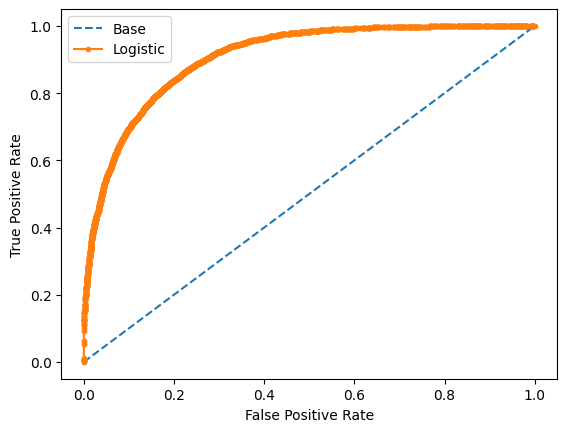

In [ ]:
proba_pred_no_resampling = pipeline_lr.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_no_resampling)

## Training a Logistic Regression Model with SMOTE - Synthetic Over-Sampling

### Build Pipeline

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_smote = ImbPipeline(steps=[
                              ("pre_process", preprocessor),
                              ("smote", SMOTE(random_state=42)), # this step runs only during training
                              ("model", lr_model)
                              ])
pipeline_smote

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('smote', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(random_state=42, solver='liblinear'))])

### Train and Evaluate Pipeline

In [ ]:
pipeline_smote.fit(X_train, y_train)

y_pred = pipeline_smote.predict(X_test)

In [ ]:
class_labels = pipeline_smote.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

,<=50K,>50K
<=50K,8927,2220
>50K,577,2929


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86     11147
        >50K       0.57      0.84      0.68      3506

    accuracy                           0.81     14653
   macro avg       0.75      0.82      0.77     14653
weighted avg       0.85      0.81      0.82     14653



Logistic: ROC AUC=0.906


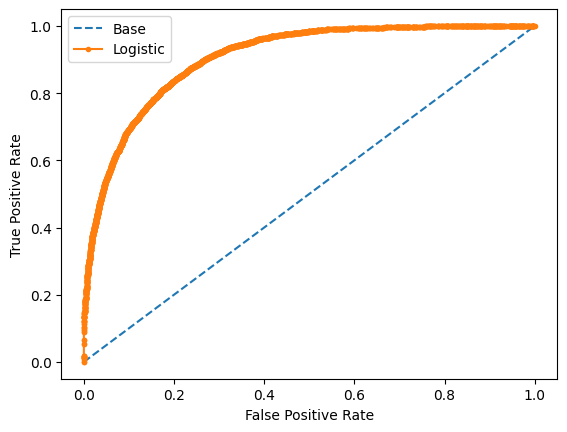

In [ ]:
proba_pred_class_wts = pipeline_smote.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_class_wts)

### Inspect Pipeline to see Sampling Effects

In [ ]:
pipeline_smote[:2]

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('smote', SMOTE(random_state=42))])

In [ ]:
X_train_res, y_train_res = pipeline_smote[:2].fit_resample(X_train, y_train)

In [ ]:
y_train_res.value_counts()

<=50K    26008
>50K     26008
Name: income, dtype: int64

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

## Training a Logistic Regression Model with Random Undersampling

### Build Pipeline

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

pipeline_rus = ImbPipeline(steps=[
                              ("pre_process", preprocessor),
                              ("rus", RandomUnderSampler(random_state=42)),
                              ("model", lr_model)
                              ])
pipeline_rus

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(random_state=42, solver='liblinear'))])

### Train and Evaluate Pipeline

In [ ]:
pipeline_rus.fit(X_train, y_train)

y_pred = pipeline_rus.predict(X_test)

In [ ]:
class_labels = pipeline_rus.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

,<=50K,>50K
<=50K,8908,2239
>50K,566,2940


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.94      0.80      0.86     11147
        >50K       0.57      0.84      0.68      3506

    accuracy                           0.81     14653
   macro avg       0.75      0.82      0.77     14653
weighted avg       0.85      0.81      0.82     14653



Logistic: ROC AUC=0.906


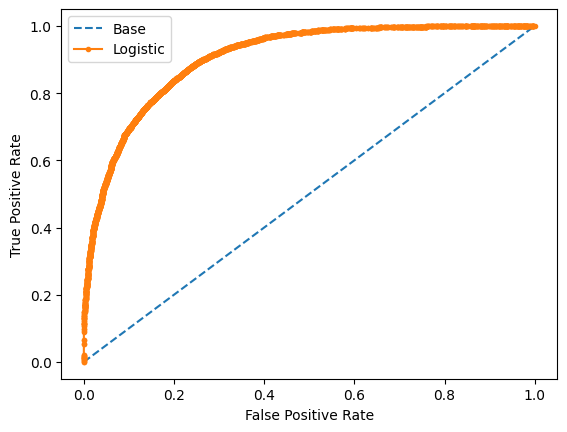

In [ ]:
proba_pred_class_wts = pipeline_rus.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_class_wts)

### Inspect Pipeline to see Sampling Effects

In [ ]:
pipeline_rus[:2]

Pipeline(steps=[('pre_process',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('knn_imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'educational-num',
                                                   'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_imputer',
                                                                   SimpleImputer(fill_value='Not '
                                                                                            'Available',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'gender',
                                                   'native-country'])])),
                ('rus', RandomUnderSampler(random_state=42))])

In [ ]:
X_train_res, y_train_res = pipeline_rus[:2].fit_resample(X_train, y_train)

In [ ]:
y_train_res.value_counts()

<=50K    8181
>50K     8181
Name: income, dtype: int64

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

## Tackling Imbalance with Class weights

In [ ]:
y_train.value_counts()

<=50K    26008
>50K      8181
Name: income, dtype: int64

### Build Pipeline

In [ ]:
lr_model2 = LogisticRegression(class_weight={'<=50K': 1,
                                           '>50K': 3},
                               random_state=42,
                               solver='liblinear')

pipeline_cw = Pipeline([("col_transformer", preprocessor),
                        ("model", lr_model2)])

### Train and Evaluate Pipeline

In [ ]:
pipeline_cw.fit(X_train, y_train)
y_pred = pipeline_cw.predict(X_test)

In [ ]:
class_labels = pipeline_cw.named_steps['model'].classes_
pd.DataFrame(confusion_matrix(y_test, y_pred),
             columns=class_labels, index=class_labels)

,<=50K,>50K
<=50K,9009,2138
>50K,593,2913


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       <=50K       0.94      0.81      0.87     11147
        >50K       0.58      0.83      0.68      3506

    accuracy                           0.81     14653
   macro avg       0.76      0.82      0.77     14653
weighted avg       0.85      0.81      0.82     14653



Logistic: ROC AUC=0.907


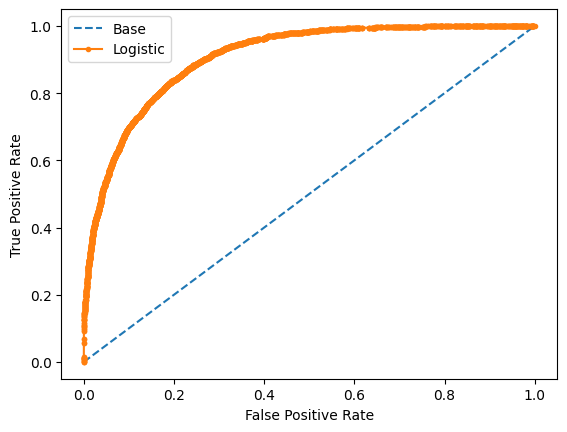

In [ ]:
proba_pred_class_wts = pipeline_cw.predict_proba(X_test)[:, 1]
plot_roc(y_test_encoded, proba_pred_class_wts)

### Selecting Custom Prediction Threshold from ROC

In [ ]:
ns_fpr, ns_tpr, thres = roc_curve(y_test_encoded, proba_pred_class_wts)

In [ ]:
df = pd.DataFrame({
    'FPR': ns_fpr,
    'TPR': ns_tpr,
    'Thresh': thres
})

df[(df['TPR'] > 0.8) & (df['FPR'] < 0.2)]

,FPR,TPR,Thresh
1963,0.167668,0.800057,0.539777
1964,0.167938,0.800057,0.539541
1965,0.167938,0.800342,0.539527
1966,0.168027,0.800342,0.539302
1967,0.168027,0.800627,0.539261
...,...,...,...
2173,0.199067,0.838562,0.490303
2174,0.199157,0.838562,0.490215
2175,0.199157,0.838848,0.489850
2176,0.199426,0.838848,0.489221


### Custom Threshold Prediction Example

In [ ]:
threshold = 0.539 # high TPR == higher recall; low FPR == higher precision
proba_pred_class_wts[:10]

array([0.78121868, 0.64887759, 0.04453078, 0.03088923, 0.01296261,
       0.14319792, 0.83012854, 0.55158442, 0.09310223, 0.00650481])

In [ ]:
preds = [1 if p > threshold else 0 for p in proba_pred_class_wts]
preds[:10]

[1, 1, 0, 0, 0, 0, 1, 1, 0, 0]

In [ ]:
pred_labels = ['<=50K' if label == 0 else '>50K' for label in preds]
pred_labels[:10]

['>50K',
 '>50K',
 '<=50K',
 '<=50K',
 '<=50K',
 '<=50K',
 '>50K',
 '>50K',
 '<=50K',
 '<=50K']

In [ ]:
print(classification_report(y_test, pred_labels))

              precision    recall  f1-score   support

       <=50K       0.93      0.83      0.88     11147
        >50K       0.60      0.80      0.69      3506

    accuracy                           0.82     14653
   macro avg       0.76      0.82      0.78     14653
weighted avg       0.85      0.82      0.83     14653

